<a href="https://colab.research.google.com/github/francesco-mannella/AdversarialWidhKeras/blob/master/notebooks/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

from __future__ import division, print_function, absolute_import

import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

First we load the mnist dataset. We only need the images (from both the train and test set) for the autoencoder. 

In [2]:
from keras.datasets import mnist

(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = 2*x_train -1
x_test = 2*x_test -1

Using TensorFlow backend.


11493376/11490434 [==============================] - 1s 0us/step


#Build the graph
We build the GAN network. We make two Sequential models for the discriminator and the generator. 

In [3]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(3e-5)

dropout = 0.2
latent_num = 100
w_stddev = 0.005

def w_init(stddev):
    return keras.initializers.RandomNormal(mean=0.0, stddev=stddev)

def dense(units, **kargs):
    return keras.layers.Dense(
        units=units,
        kernel_initializer=w_init(w_stddev),
        bias_initializer=w_init(w_stddev),
        **kargs)
                       
# discriminator 
discriminator = keras.models.Sequential(name="discriminator_net")
discriminator.add(keras.layers.Input(shape=(28,28)))
discriminator.add(keras.layers.Flatten(name="flattened_input"))
discriminator.add(keras.layers.Dropout(dropout))
discriminator.add(dense(units=1024, name="dL1"))
discriminator.add(keras.layers.ReLU())
discriminator.add(keras.layers.Dropout(dropout))
discriminator.add(dense(512, name="dL2"))
discriminator.add(keras.layers.ReLU())
discriminator.add(keras.layers.Dropout(dropout))
discriminator.add(dense(256, name="dL3"))
discriminator.add(keras.layers.ReLU())
discriminator.add(keras.layers.Dropout(dropout))
discriminator.add(dense(1, activation="sigmoid", name="prob"))

# generator
generator = keras.models.Sequential(name="generator_net")
generator.add(keras.layers.Input(shape=(latent_num,)))
generator.add(dense(256, name="gL1"))
generator.add(keras.layers.ReLU())
generator.add(dense(512, name="gL2"))
generator.add(keras.layers.ReLU())
generator.add(dense(1024,  name="gL3"))
generator.add(keras.layers.ReLU())
generator.add(dense(28*28,  name="output"))
generator.add(keras.layers.Reshape((28, 28), name="unflattened_output"))

input_images = discriminator.input
generated_patterns = generator.input

discriminator.trainable = True
generator.trainable = False
discriminator_model = keras.models.Model(name="discriminator",
    inputs=input_images, outputs=discriminator(input_images))
discriminator_model.compile(optimizer=optimizer, loss='binary_crossentropy')

discriminator.trainable = False
generator.trainable = True  
generated_images = generator(generated_patterns)
adversarial_model = keras.models.Model(name="adversarial",
    inputs=generated_patterns, outputs=discriminator(generated_images))
adversarial_model.compile(optimizer, loss='binary_crossentropy')


W0903 04:31:18.465351 140577869502336 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:143: calling RandomNormal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0903 04:31:18.937971 140577869502336 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
num_epochs  = 100
batch_size = 30
epochs_to_show = 10

img_indices = np.arange(x_train.shape[0])
num_imgs = len(img_indices)
batch_num = num_imgs//batch_size

def noise(size):
    x = np.random.normal(0,1, [size, latent_num])
    return x

noise_test = noise(25)

In [0]:
%matplotlib inline
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

epoch: 99 dloss: 0.2601484  aloss: 2.1640539 


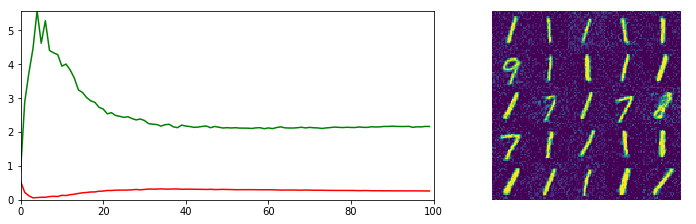

In [6]:
fig = plt.figure(figsize=(10,3), constrained_layout=True)
gs = fig.add_gridspec(1, 5)

ax1 = fig.add_subplot(gs[:,:-2])
dplot, = ax1.plot(0,0, c="red")
gplot, = ax1.plot(0,0, c="green")

ax2 = fig.add_subplot(gs[:,-2:], aspect="auto")
imgs = ax2.imshow(np.zeros([2,2]), vmin = -1, vmax = 1)
ax2.set_axis_off()

def plot(epoch, dloss, aloss):
        dplot.set_data(np.arange(len(dloss)), dloss)
        gplot.set_data(np.arange(len(aloss)), aloss)
        ax1.set_xlim([0, len(dloss)])
        ax1.set_ylim([0,np.max([aloss, dloss])])

        test_gen_batch = generator.predict(noise_test).reshape(5,5,28,28)
        imgs.set_data(np.vstack([np.hstack([img for img in test_gen_row])
                              for test_gen_row in test_gen_batch]))
        display.clear_output(wait=True)
        print("epoch: %d dloss: %-10.7f aloss: %-10.7f" % (
            epoch, dloss[-1], aloss[-1]))
        display.display(plt.gcf())  


dloss = []
aloss = []
curr_dloss = 0.0
curr_aloss = 0.0
for epoch in range(num_epochs):
    np.random.shuffle(img_indices)
    train_imgs = x_train[img_indices,...]
    epoch_dloss = [] 
    epoch_aloss = [] 
    for batch in range(batch_num):
        curr_batch = train_imgs[batch*batch_size:(batch + 1)*batch_size]
        discr_gen = noise(batch_size)
        discr_gen_batch = generator.predict(discr_gen)

        curr_dloss = discriminator_model.train_on_batch(
            np.vstack((curr_batch, discr_gen_batch)), 
            np.hstack((np.ones(batch_size), np.zeros(batch_size))))
 
        adv_gen = noise(batch_size)
        curr_aloss = adversarial_model.train_on_batch(
            adv_gen, 
            np.ones(batch_size))

        epoch_dloss.append(curr_dloss)
        epoch_aloss.append(curr_aloss)
        
    dloss.append(np.mean(epoch_dloss))
    aloss.append(np.mean(epoch_aloss))
    
    if epoch%epochs_to_show == 0 or epoch == (num_epochs - 1):
         plot(epoch, dloss, aloss)
    